In [1]:
import os
import re
import fitz  # PyMuPDF
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

C:\ProgramData\anaconda3\envs\bert_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Base folder containing PDFs and labels.xlsx
DATA_PATH = r"C:\Users\ashwa\Desktop\ESG data\data"

LABELS_PATH = os.path.join(DATA_PATH, "labels.xlsx")


# Global label mapping
LABEL_MAP = {'E': 0, 'S': 1, 'G': 2}

INV_LABEL_MAP = {0: 'Environmental', 1: 'Social', 2: 'Governance'}

In [3]:
# text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [4]:
# load labelled data
df = pd.read_excel(LABELS_PATH)
df = df[df['class'].isin(['E', 'S', 'G'])]

def parse_id(id_value):
    pdf_name, page = id_value.rsplit('_', 1)
    return pdf_name, int(page)

df[['pdf_name', 'page_number']] = df['id'].apply(
    lambda x: pd.Series(parse_id(x))
)

In [5]:
# valid ESG labels
print("Clean dataset shape:", df.shape)
print(df['class'].value_counts())

Clean dataset shape: (1124, 4)
class
E    467
G    445
S    212
Name: count, dtype: int64


In [6]:
# PDF text extraction
def read_page_text(pdf_name, page_number):
    pdf_path = os.path.join(DATA_PATH, pdf_name)

    with fitz.open(pdf_path) as doc:
        page = doc.load_page(page_number - 1)
        text = page.get_text()

    return clean_text(text)

In [7]:
# building text dataset
df['text'] = df.apply(
    lambda r: read_page_text(r['pdf_name'], r['page_number']),
    axis=1
)

# Remove pages with almost no text
df = df[df['text'].str.len() > 50]
df['label'] = df['class'].map(LABEL_MAP)

print("Final usable samples:", df.shape[0])

Final usable samples: 1124


In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=40,
    stratify=df['label']
)

In [9]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
# custom class for dataset
class ESGDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts.iloc[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }


In [11]:
# dataset objects
train_dataset = ESGDataset(X_train, y_train, tokenizer)
test_dataset = ESGDataset(X_test, y_test, tokenizer)

# loadaing pre-trained BERT
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 629.99it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

In [12]:
# model training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
C:\ProgramData\anaconda3\envs\bert_env\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,0.768353,0.374998
2,0.558694,0.222184
3,0.135919,0.255864


TrainOutput(global_step=339, training_loss=0.35965066174578175, metrics={'train_runtime': 5786.7854, 'train_samples_per_second': 0.466, 'train_steps_per_second': 0.059, 'total_flos': 709616887612416.0, 'train_loss': 0.35965066174578175, 'epoch': 3.0})

In [13]:
# ckecking trained model performance on unseen label data
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    y_test,
    y_pred,
    target_names=['Environmental', 'Social', 'Governance']
))

               precision    recall  f1-score   support

Environmental       0.96      0.95      0.95        94
       Social       0.88      0.83      0.85        42
   Governance       0.91      0.94      0.93        89

     accuracy                           0.92       225
    macro avg       0.92      0.91      0.91       225
 weighted avg       0.92      0.92      0.92       225



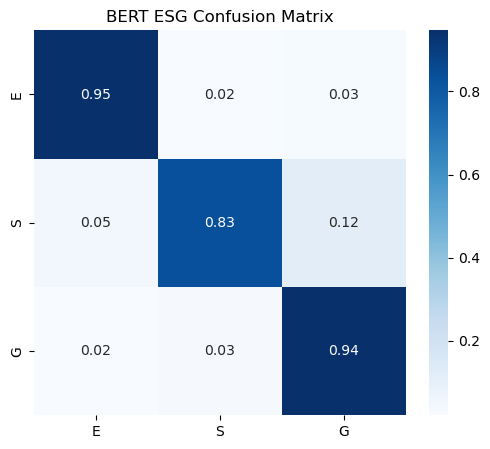

In [14]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['E', 'S', 'G'],
    yticklabels=['E', 'S', 'G']
)
plt.title("BERT ESG Confusion Matrix")
plt.show()

In [15]:
# single page ESG prediction
def predict_esg(pdf_name, page_number):
    pdf_path = os.path.join(DATA_PATH, pdf_name)

    with fitz.open(pdf_path) as doc:
        text = doc.load_page(page_number - 1).get_text()

    text = clean_text(text)

    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**encoding)

    pred = torch.argmax(outputs.logits, dim=1).item()

    return INV_LABEL_MAP[pred]


In [18]:
# pdf name and page classification
predict_esg("report_12.pdf", 15)

'Environmental'

In [16]:
# ESG classification of a new PDF
def classify_pdf(pdf_name, min_text_length=50):
    """
    Classify all pages of a PDF into ESG categories using BERT.
    Returns a DataFrame with page-level predictions.
    """

    pdf_path = os.path.join(DATA_PATH, pdf_name)

    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"{pdf_name} not found in {DATA_PATH}")

    texts = []
    page_numbers = []

    with fitz.open(pdf_path) as doc:
        for page_num in range(len(doc)):
            text = doc.load_page(page_num).get_text()

            if text and len(text) >= min_text_length:
                texts.append(clean_text(text))
                page_numbers.append(page_num + 1)

    if not texts:
        return pd.DataFrame(columns=["pdf_name", "page_number", "predicted_esg"])

    # Batch Tokenization (much faster than one-by-one)
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**encodings)

    predictions = torch.argmax(outputs.logits, dim=1).numpy()

    results = pd.DataFrame({
        "pdf_name": pdf_name,
        "page_number": page_numbers,
        "predicted_esg": [INV_LABEL_MAP[p] for p in predictions]
    })

    return results


df_pdf_esg = classify_pdf("REPORT.pdf")
df_pdf_esg.head()

,pdf_name,page_number,predicted_esg
0,REPORT.pdf,1,Environmental
1,REPORT.pdf,2,Governance
2,REPORT.pdf,3,Environmental
3,REPORT.pdf,4,Environmental
4,REPORT.pdf,5,Environmental


In [17]:
# document level ESG summary
def summarize_pdf_esg(pdf_name):
    """
    Returns percentage distribution of ESG categories for entire PDF.
    """

    df_pages = classify_pdf(pdf_name)

    if df_pages.empty:
        return "No valid pages found."

    summary = (
        df_pages['predicted_esg']
        .value_counts(normalize=True)
        .mul(100)
        .round(2)
    )

    return summary

summarize_pdf_esg("REPORT.pdf")

predicted_esg
Governance       53.33
Environmental    33.33
Social           13.33
Name: proportion, dtype: float64

In [19]:
# saving model
trainer.save_model("esg_bert_model")
tokenizer.save_pretrained("esg_bert_model")

Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


('esg_bert_model\\tokenizer_config.json', 'esg_bert_model\\tokenizer.json')